# Crystallization Modelling Notebook
This notebook illustrates possibility of controlling the laboratory crystallization module hardware using advanced programming (e.g. this Python Jupyter notebook).

### Use
- goto top menu [Cell] --> [Run All]
    - The bottom illustrates a continuously updated plot that is receiving data from the crystallization module.
    - Note that the plot updates at the frequency that the crystallization module sends new data. Thus, the plot may not appear to be changing - be patient.

### Details
- The first cell imports the necessary modules to connect to the crystallization module and imports some auxillary modules to aid in calculating and plotting results.
- The second module creates a thread that connects and listens to the crystallization module websocket.
- The third cell 
The first cell will demonstrated connecting to the crystallizer computer and retrieving real-time hardware present values. In particular, the values of the TCUs will be read and plotted in real time. 
    - This exemplifies reading current state of modules that can be used for advanced calculations/modelling.
    - To further confirm the communication, open the main UI and observe that the UI TCU values agree with the data read by this notebook.
- The second cell demonstrates updating hardware set points. In this case, the setpoints of the stirrers are varried sinusoidally (rediculous but demonstratable effect).
    - This illustrates setting the hardware setpoints based off of a possible advanced model.
    - To confirm the send values, open the main UI and observe that the UI stirrer values are changing with the values send by this notebook.

#### Importing the needed modules

In [2]:
import websocket
import numpy as np
import json
import threading
from datetime import datetime
from matplotlib import pyplot as plt
from time import sleep

<IPython.core.display.Javascript object>


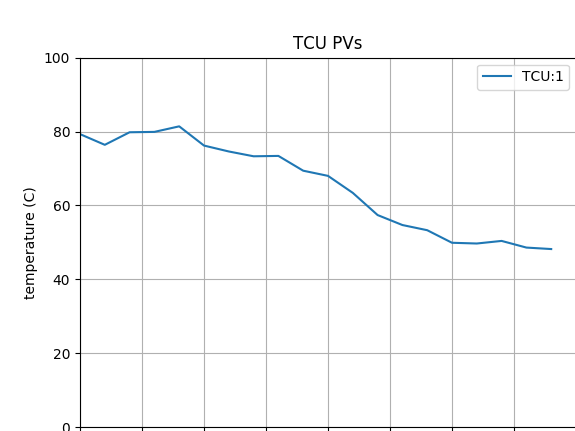

KeyboardInterrupt: 

In [3]:
class CrystallizationModel(object):
    """Demonstrate the possibility of deploying an advanced modelling interface
    using a Jupyter notebook.
    """

    def __init__(self): 
        """Start the web client in a thread."""
        
        self.data = []
        t = threading.Thread(target=self.start_websocket_listener)
        t.start()
        
        self.create_plot()
        
        self.update()

    def start_websocket_listener(self):
        """Create the websocket client and append data to the class variable."""
        #websocket.enableTrace(True)
        
        def on_open(ws):
            #print("open")
            pass

        def on_error(ws, error):
            print(error)

        def on_close(ws):
            ws.send("Watson Studio Listen End")

        def on_message(ws, msg):
            msg = json.loads(msg)
            if msg["equipment"] == "TCU:1":
                if msg["command"] =="BATH:TEMP:PV":
                    self.data.append(float(msg["value"]))
                    
        self.ws = websocket.WebSocketApp("ws://10.131.72.83:1880/ws/crystallizer",
                                    on_message = on_message,
                                    on_error =on_error,
                                    on_close = on_close
        )
        self.ws.on_open = on_open
        self.ws.run_forever()

    def create_plot(self):
        """Create the matplotlib figure."""
        %matplotlib notebook
        fig,ax = plt.subplots(1,1)
        ax.plot([0]*20, label='TCU:1')
        ax.legend()
        ax.set_xlim(0,20)
        ax.set_ylim(0,100)
        ax.set_xlabel('timesteps')
        ax.set_ylabel('temperature (C)')
        ax.grid()
        ax.set_title('TCU PVs')
        self.ax = ax
        self.fig = fig
        
    def model(self):
        """Calculate new setpoints (e.g. "Advanced Model Control")
        """
        TCU_1_SP = 60 + 30 * np.sin(datetime.now().minute / 60. * 2*3.141 * 10)
        new_state = json.dumps({"equipment": "TCU:1", "command": "TEMP0:SP", "value": TCU_1_SP})
        return new_state
        
    def update(self):  
        """Update plot with current PVs, and send new 
        setpoints.
        """
        
        while True:
            line = self.ax.lines[0]
            line.set_xdata(range(len(self.data[-20:])))
            line.set_ydata(self.data[-20:])
            self.fig.canvas.draw()
            self.ws.send(self.model())
            sleep(10)


model = CrystallizationModel()
